## MaskRCNN application to isntance segmentation of Laue spots

### Generate simulated 2D Gaussian peaks with segmentation as ground truth
### Train a MaskRCNN network with pretrained weights from COCO database
### As of now, it works as peak detection routine, by segmenting only the peaks from the Laue image

### Potential: Training a clas sof small peaks to extract only the small peaks / or large peaks / or overlapping peaks/ or isolated peaks

In [1]:
## Import required libraries
import numpy as np
import cv2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.utils.data
import torchvision.models.segmentation
import torch
from tqdm import trange
import time
from tqdm import trange
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)


cpu


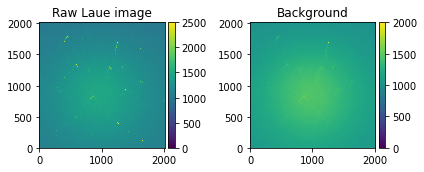

In [2]:
## Load a background of the Laue image
## Somehow intensity affects a lot on the segmentation
# ## Load real Laue image
images_raw = plt.imread(r"Ni_laue.tiff")
images_raw = images_raw.astype(float)
##remove background
from lauetoolsnn.lauetools import imageprocessing as ImProc
framedim = images_raw.shape
CCDLabel = 'sCMOS'
backgroundimage = ImProc.compute_autobackground_image(images_raw, boxsizefilter=10)

fig, ax = plt.subplots(1,2)
vmin = 0
vmax = 2500
ax[0].title.set_text("Raw Laue image")
if vmin!=None or vmax!=None:
    img000 = ax[0].imshow(images_raw, origin='lower', interpolation='None', vmin= vmin, vmax=vmax)
else:
    img000 = ax[0].imshow(images_raw, origin='lower', interpolation='None')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img000, cax=cax, orientation='vertical')

vmin = 0
vmax = 2000
ax[1].title.set_text("Background")
if vmin!=None or vmax!=None:
    img001 = ax[1].imshow(backgroundimage, origin='lower', interpolation='None', vmin= vmin, vmax=vmax)
else:
    img001 = ax[1].imshow(backgroundimage, origin='lower', interpolation='None')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img001, cax=cax, orientation='vertical')
fig.tight_layout()
plt.show()

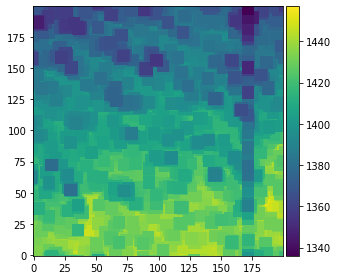

In [3]:
img_size = (100,100)
xcen, ycen = np.random.randint(0+img_size[0],backgroundimage.shape[0]-img_size[0]), np.random.randint(0+img_size[1],backgroundimage.shape[1]-img_size[1])
noiseonlyimage = backgroundimage[xcen-img_size[0]:xcen+img_size[0],ycen-img_size[1]:ycen+img_size[1]]

fig, ax = plt.subplots()
img000 = ax.imshow(noiseonlyimage, origin='lower', interpolation='None',)# vmin= 50, vmax=1000)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img000, cax=cax, orientation='vertical')
fig.tight_layout()
plt.show()

### FUNCTIONS

In [6]:
def makeGaussian2(intensity=500, x_center=50, y_center=50, theta=0, sigma_x = 10, sigma_y=10, x_size=100, y_size=100):
    theta = 2*np.pi*theta/360
    x = np.arange(0, x_size, 1, float)
    y = np.arange(0, y_size, 1, float)
    y = y[:,np.newaxis]
    # a=np.cos(theta)*x -np.sin(theta)*y
    a=np.cos(theta)*x[:,np.newaxis] -np.sin(theta)*y[:,np.newaxis]
    # b=np.sin(theta)*x +np.cos(theta)*y
    b=np.sin(theta)*x[:,np.newaxis] +np.cos(theta)*y[:,np.newaxis]
    a0=np.cos(theta)*x_center -np.sin(theta)*y_center
    b0=np.sin(theta)*x_center +np.cos(theta)*y_center
    return intensity* (np.exp(-(((a-a0)**2)/(2*(sigma_x**2)) + ((b-b0)**2) /(2*(sigma_y**2)))))

def convert_binary(image_matrix):
    im_bw_comb = np.zeros((image_matrix.shape))
    for i in range(image_matrix.shape[2]):
        im_bw = cv2.threshold(image_matrix[:,:,i], 100, 255, cv2.THRESH_BINARY)[1]
        im_bw[im_bw<1] = 0
        im_bw[im_bw>1] = 1
        im_bw_comb[:,:,i] = im_bw
    return im_bw_comb

def generate_data(nb_peaks, img_size=(100,100), seed=None):
    # =============================================================================
    # Poisson noise
    # =============================================================================
    ## poisson noise
    #myimage = 50 * np.ones(img_size) #--> give noise max of 30cts
    #imageplusnoise = np.random.poisson(lam=myimage, size=None)        
    #noiseonlyimage = imageplusnoise - myimage
    
    ## add real experimental Noise for a given dataset
    halfTargetSize = img_size[0]//2
    xcen, ycen = np.random.randint(0+halfTargetSize,backgroundimage.shape[0]-halfTargetSize), np.random.randint(0+halfTargetSize,backgroundimage.shape[1]-halfTargetSize)
    noiseonlyimage = backgroundimage[xcen-halfTargetSize:xcen+halfTargetSize,ycen-halfTargetSize:ycen+halfTargetSize]
        
    if seed != None:
        np.random.seed(seed)
    size = np.random.uniform(low=1, high=8, size=nb_peaks)
    intensity = np.random.uniform(low=500, high=5000, size=nb_peaks)
    ellipse_axe1 = np.random.uniform(low=0.5, high=1.5, size=nb_peaks)
    ellipse_axe2 = np.random.uniform(low=0.5, high=1.5, size=nb_peaks)
    center_x = np.random.randint(0,img_size[0], size=nb_peaks)
    center_y = np.random.randint(0,img_size[1], size=nb_peaks)
    angle = np.random.randint(0,180, size=nb_peaks)
    ## Elongated Gaussian with random angles
    images = makeGaussian2(intensity=1, 
                         x_center=center_x, 
                         y_center=center_y,
                         theta = angle, 
                         sigma_x = ellipse_axe1*size, 
                         sigma_y = ellipse_axe2*size,
                         x_size=img_size[0], 
                         y_size=img_size[1])
    images = intensity*images
    ##for groundtruth in MaskRCnn
    mask_separate = convert_binary(images)    
    images = images.sum(axis=2)
    ## Add noise
    images = images + noiseonlyimage
    images = np.abs(images)
    mask_separate = np.transpose(mask_separate, axes=(2,0,1))
    return images, mask_separate

def loadData(img_size):
    batch_Imgs=[]
    batch_Data=[]
    for i in range(batchSize):
        num_objs = int(np.random.randint(low=10, high=50))
        img, masks = generate_data(num_objs, img_size=img_size)
        img = img.reshape((img.shape[0], img.shape[1], 1))
        if np.any(np.sum(masks, axis=(1,2)) == 0): 
            return loadData(img_size) # if mask is not segmented properly, do the loop again
        masks = masks.astype(np.uint8)
        boxes = torch.zeros([num_objs,4], dtype=torch.float32)
        for i in range(num_objs):
            x,y,w,h = cv2.boundingRect(masks[i])
            boxes[i] = torch.tensor([x, y, x+w, y+h])
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        img = torch.as_tensor(img, dtype=torch.float32)
        data = {}
        data["boxes"] = boxes
        data["labels"] = torch.ones((num_objs,), dtype=torch.int64)   # there is only one class
        data["masks"] = masks
        batch_Imgs.append(img)
        batch_Data.append(data)  # load images and masks
    batch_Imgs_torch = torch.stack([torch.as_tensor(d) for d in batch_Imgs], 0)
    batch_Imgs_torch = batch_Imgs_torch.swapaxes(1, 3).swapaxes(2, 3)
    return batch_Imgs_torch, batch_Data

def start_points(size, split_size, overlap=0):
    points = [0]
    stride = int(split_size * (1-overlap))
    counter = 1
    while True:
        pt = stride * counter
        if pt + split_size >= size:
            points.append(size - split_size)
            break
        else:
            points.append(pt)
        counter += 1
    return points

def blockshaped(arr, split_height, split_width, overlap_kernal = 0.0):
    image_set = []
    img_h, img_w = arr.shape[:2]
    X_points = start_points(img_w, split_width, overlap_kernal)
    Y_points = start_points(img_h, split_height, overlap_kernal)
    count = 0
    if len(arr.shape) == 2:
        for i in Y_points:
            for j in X_points:
                split = arr[i:i+split_height, j:j+split_width]
                image_set.append(split)
                count += 1
        return count, np.array(image_set)
    elif len(arr.shape) == 3:
        for i in Y_points:
            for j in X_points:
                split = arr[i:i+split_height, j:j+split_width, :]
                image_set.append(split)
                count += 1
        return count, np.array(image_set)

## Lets generate some dataset and verify visually

In [19]:
nImages = 50
imgSize = 512

images = []
peaks = []
labels = []
for i in trange(nImages):
    num_objs = int(np.random.randint(low=10, high=50))
    img, mask_ = generate_data(num_objs, img_size=(imgSize, imgSize))
    images.append(img)
    labels.append(mask_)
    peaks.append(num_objs)

100%|██████████| 50/50 [00:13<00:00,  3.61it/s]


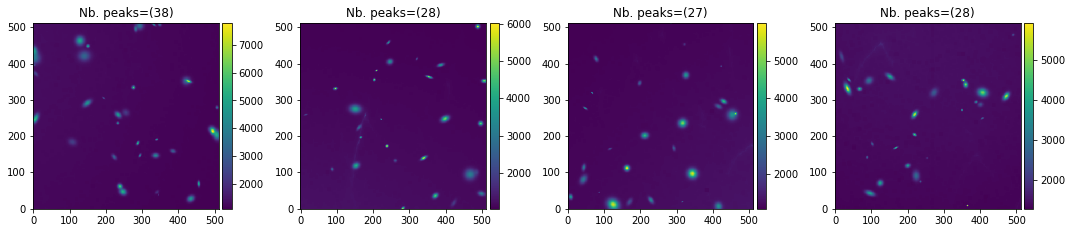

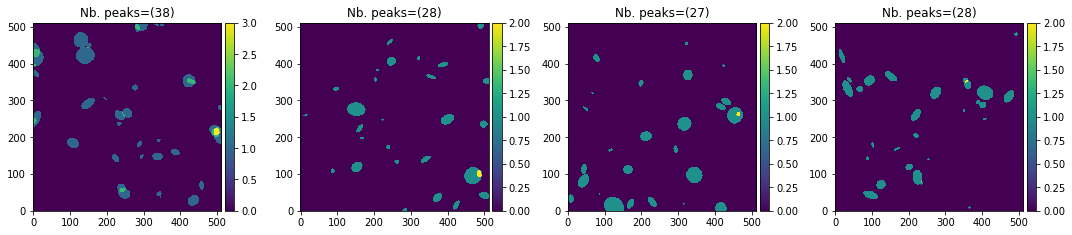

In [23]:
# visualize some images randomly
indices = []
fig,axs = plt.subplots(1,4,figsize=(15,7))
for i,ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nImages)
    img000 = ax.imshow(images[whichpic], origin='lower', interpolation='None')#, vmin= 50, vmax=1000)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(img000, cax=cax, orientation='vertical')
    ax.set_title(f'Nb. peaks=({peaks[whichpic]:.0f})')
    indices.append(whichpic)
plt.tight_layout()
plt.show()
##Visualize labels
fig,axs = plt.subplots(1,4,figsize=(15,7))
for i,ax in enumerate(axs.flatten()):
    whichpic = indices[i]
    img000 = ax.imshow(labels[whichpic].sum(axis=0), origin='lower', interpolation='None')#, vmin= 50, vmax=1000)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(img000, cax=cax, orientation='vertical')
    ax.set_title(f'Nb. peaks=({peaks[whichpic]:.0f})')
plt.tight_layout()
plt.show()

## Lets Train

In [ ]:
###simple version of maskRCNN without FPN as in the original article
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='MaskRCNN_ResNet50_FPN_Weights.DEFAULT')  # load an instance segmentation model pre-trained pre-trained on COCO
in_features = model.roi_heads.box_predictor.cls_score.in_features  # get number of input features for the classifier
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)  # replace the pre-trained head with a new one
model.to(device) # move model to the right device
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-4)
model.train()

batchSize = 1
pbar = trange(1001, desc='loss:', leave=True)
for i in pbar:
    images, targets = loadData(img_size = (512,512))
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())
    losses.backward()
    optimizer.step()
    #print(i,'loss:', losses.item())
    pbar.set_description('loss:%s'%losses.item())
    pbar.refresh() # to show immediately the update
    time.sleep(0.01)
    if i%500==0:
        torch.save(model.state_dict(), str(i)+".torch")


loss:3.269052267074585:  53%|█████▎    | 533/1001 [27:22<25:41,  3.29s/it]  

## Lets test the model with a prediction on real laue image

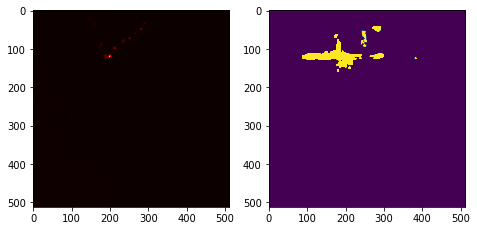

In [15]:
#% Validate the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')   # train on the GPU or on the CPU, if a GPU is not available
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=True)  # load an instance segmentation model pre-trained pre-trained on COCO
in_features = model.roi_heads.box_predictor.cls_score.in_features  # get number of input features for the classifier
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)  # replace the pre-trained head with a new one
model.load_state_dict(torch.load("500.torch"))
model.to(device)# move model to the right devic
model.eval()

simulated = False
target_size = 512
complete_image = False


if simulated:
    # =============================================================================
    # ## simulated dataset
    # =============================================================================
    num_objs = int(np.random.randint(low=10, high=100))
    images_raw, masks = generate_data(num_objs, img_size=(512,512))
    label = list(range(num_objs))
else:
    # =============================================================================
    # Experimental dataset
    # =============================================================================
    # ## Load real Laue image
    images_raw = plt.imread(r"Ni_laue.tiff")
    images_raw = images_raw/1.
    
    ##remove background
    from lauetoolsnn.lauetools import imageprocessing as ImProc
    framedim = images_raw.shape
    CCDLabel = 'sCMOS'
    backgroundimage = ImProc.compute_autobackground_image(images_raw, boxsizefilter=10)
    # basic substraction
    images_raw = ImProc.computefilteredimage(images_raw, backgroundimage, 
                                                CCDLabel, usemask=False, formulaexpression="A-B")
    images_raw[0:10, :] = 0
    images_raw[:, 0:10] = 0
    
    # Crop size
    imgR, imgC, overlap = 512, 512, 0.05
    # All crops
    crops_nb, all_crops = blockshaped(images_raw, split_height = imgR, split_width = imgC, overlap_kernal = overlap)
    images_raw = images_raw.reshape((images_raw.shape[0], images_raw.shape[1], 1))
    label = list(range(5000))


if simulated:
    images_cropped_raw = np.copy(images_raw)
    images_cropped = images_cropped_raw
    images = images_cropped.reshape((images_cropped.shape[0], images_cropped.shape[1], 1))
    images = torch.as_tensor(images, dtype=torch.float32).unsqueeze(0)
    images = images.swapaxes(1, 3).swapaxes(2, 3)
    images = list(image.to(device) for image in images)
    with torch.no_grad():
        pred = model(images)
    im2 = np.zeros((target_size,target_size,1))
    for i in range(len(pred[0]['masks'])):
        msk=pred[0]['masks'][i,0].detach().cpu().numpy()
        scr=pred[0]['scores'][i].detach().cpu().numpy()
        if scr>0.8:
            im2[:,:,0][msk>0.5] = np.random.choice(label, 1, replace=False)
elif complete_image == False:
    ## to have the same intensity as training dataset (of about 150cts)
    images_cropped_raw = all_crops[3]
    # images_cropped[images_cropped<100] = 0
    if images_cropped_raw.max() < 100:
        print("no peaks in the image")
    images_cropped = images_cropped_raw #/(images_cropped_raw.max()/1200)
    images = images_cropped.reshape((images_cropped.shape[0], images_cropped.shape[1], 1))
    images = torch.as_tensor(images, dtype=torch.float32).unsqueeze(0)
    images = images.swapaxes(1, 3).swapaxes(2, 3)
    images = list(image.to(device) for image in images)
    with torch.no_grad():
        pred = model(images)
    im2 = np.zeros((target_size,target_size,1))
    for i in range(len(pred[0]['masks'])):
        msk=pred[0]['masks'][i,0].detach().cpu().numpy()
        scr=pred[0]['scores'][i].detach().cpu().numpy()
        if scr>0.75:
            im2[:,:,0][msk>0.5] = np.random.choice(label, 1, replace=False)
else:
    ## reconstruct the complete Laue image
    images_cropped_raw = np.copy(images_raw)
    ##To make images 2048 dimension
    pad_width = ((15, 15), (16, 16), (0, 0))
    pad_x = np.pad(images_cropped_raw, pad_width, 'edge')
    pad_y = np.zeros((pad_x.shape[0], pad_x.shape[1], 1))
    row_begin_list = list(range(0, pad_x.shape[0], target_size))
    col_begin_list = list(range(0, pad_x.shape[1], target_size))
    
    for rw_ind in trange(len(row_begin_list)):
        row_begin = row_begin_list[rw_ind]
        for col_begin in col_begin_list:
            row_end = row_begin + target_size
            col_end = col_begin + target_size
            if row_end <= pad_x.shape[0] and col_end <= pad_x.shape[1]:
                x_window = pad_x[row_begin:row_end, col_begin:col_end, :]
                ## to have the same intensity as training dataset (of about 150cts)
                #x_window = x_window/(x_window.max()/1200)
                x_window = torch.as_tensor(x_window, dtype=torch.float32).unsqueeze(0)
                x_window = x_window.swapaxes(1, 3).swapaxes(2, 3)
                x_window = list(image.to(device) for image in x_window)
                with torch.no_grad():
                    pred = model(x_window)
                y_window = np.zeros((target_size,target_size,1))
                for i in range(len(pred[0]['masks'])):
                    msk=pred[0]['masks'][i,0].detach().cpu().numpy()
                    scr=pred[0]['scores'][i].detach().cpu().numpy()
                    if scr>0.8:
                        y_window[:,:,0][msk>0.5] = np.random.choice(label, 1, replace=False)
                y_window_center = y_window[15:target_size-15,15:target_size-15,:]
                pad_y[row_begin+15:row_end-15,col_begin+15:col_end-15,:] = y_window_center
    im2 = pad_y[15:15+images_cropped_raw.shape[0],15:15+images_cropped_raw.shape[1],:]
        
fig,ax = plt.subplots(1,2)
fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
ax[0].imshow(images_cropped_raw, cmap='hot')#, vmax=100)
ax[1].imshow(im2, vmax=len(np.unique(im2)))
plt.show()

if simulated:
    fig,ax = plt.subplots(1,2)
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    ax[0].imshow(masks.sum(axis=0))
    ax[1].imshow(im2)
    plt.show()